## Reliable-RAG 🏷️

### Overview

The "Reliable-RAG" method enhances the traditional Retrieval-Augmented Generation (RAG) approach by adding layers of validation and refinement to ensure the accuracy and relevance of retrieved information. This system is designed to process and query web-based documents, encode their content into a vector store, and retrieve the most relevant segments for generating precise and reliable answers. The method incorporates checks for document relevancy, hallucination prevention, and highlights the exact segments used in generating the final response.

### Key Components

1. **Document Loading and Chunking:** 
   - Web-based documents are loaded and split into smaller, manageable chunks to facilitate efficient vector encoding and retrieval.

2. **Vectorstore Creation:**
   - Utilizes Chroma and Cohere embeddings to encode document chunks into a vector store, enabling efficient similarity-based retrieval.

3. **Document Relevancy Check:**
   - Implements a relevance-checking mechanism using a language model to filter out non-relevant documents before answer generation.

4. **Answer Generation:**
   - Employs a language model to generate concise answers based on the relevant documents retrieved.

5. **Hallucination Detection:**
   - A dedicated hallucination detection step ensures that the generated answers are grounded in the retrieved documents, preventing the inclusion of unsupported or erroneous information.

6. **Document Snippet Highlighting:**
   - The system identifies and highlights the specific document segments that were directly used to generate the answer, providing transparency and traceability.

### Motivation

The Reliable-RAG method was developed to address the common challenges faced in traditional RAG systems, such as retrieving irrelevant documents, generating answers that are not grounded in facts, and the lack of transparency in the sources used for answer generation. By adding multiple layers of validation, this method ensures that the answers provided are both accurate and reliable.

### Method Details and Benefits

- **Document Relevancy Filtering:** 
  By using a binary relevancy score generated by a language model, only the most relevant documents are passed on to the answer generation phase, reducing noise and improving the quality of the final answer.

- **Hallucination Check:**
  Before finalizing the answer, the system checks for hallucinations by verifying that the generated content is fully supported by the retrieved documents.

- **Snippet Highlighting:** 
  This feature enhances transparency by showing the exact segments from the retrieved documents that contributed to the final answer.

## Implementation

### Step-by-Step Python Implementation

1. **Import Libraries and Set Environment Variables**
   - Import necessary libraries and set environment variables for LLM and embedding model access.

2. **Create Vectorstore**
   - Load web-based documents, split them into chunks, and create a vector store using Chroma and Cohere embeddings.

3. **Question Query**
   - Define the user query and retrieve the top relevant documents from the vector store.

4. **Check Document Relevancy**
   - Filter out non-relevant documents using a binary relevancy score provided by a language model.

5. **Generate Answer**
   - Use the relevant documents to generate a concise answer to the user query.

6. **Check for Hallucinations**
   - Ensure that the generated answer is fully grounded in the retrieved documents.

7. **Highlight Document Snippets**
   - Identify and highlight the exact segments from the retrieved documents that were used to generate the final answer.

### Additional Considerations

- **Limitations:** The system's performance is dependent on the quality of the embeddings and the effectiveness of the hallucination detection mechanism.
- **Potential Improvements:** Incorporating more sophisticated models for relevancy checking and hallucination detection could further enhance the system's reliability.
- **Specific Use Cases:** This method is particularly useful in domains where factual accuracy and transparency are paramount, such as legal or academic research.

### Visual Representation

<img src="../images/reliable_rag.svg" alt="Reliable-RAG" width="300">

###  Import Libraries and enviornment variables

In [1]:
### LLMs
import os
from dotenv import load_dotenv

# Load environment variables from '.env' file
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY') # For LLM -- llama-3.1-8b (small) & mixtral-8x7b-32768 (large)
os.environ['COHERE_API_KEY'] = os.getenv('COHERE_API_KEY') # For embedding

### Create Vectorstore

In [2]:
### Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_cohere import CohereEmbeddings

# Set embeddings
embedding_model = CohereEmbeddings(model="embed-english-v3.0")

# Docs to index
urls = [
    "https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-2-reflection/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-3-tool-use/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-4-planning/?ref=dl-staging-website.ghost.io",
    "https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-5-multi-agent-collaboration/?ref=dl-staging-website.ghost.io"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag",
    embedding=embedding_model,
)

retriever = vectorstore.as_retriever(
                search_type="similarity",
                search_kwargs={'k': 4}, # number of documents to retrieve
            )

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Question

In [3]:
question = "what are the differnt kind of agentic design patterns?"

### Retrieve docs

In [4]:
docs = retriever.invoke(question)

### Check what our doc looklike

In [5]:
print(f"Title: {docs[0].metadata['title']}\n\nSource: {docs[0].metadata['source']}\n\nContent: {docs[0].page_content}\n")

Title: Four AI Agent Strategies That Improve GPT-4 and GPT-3.5 Performance

Source: https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/?ref=dl-staging-website.ghost.io

Content: GPT-3.5 to GPT-4 is dwarfed by incorporating an iterative agent workflow. Indeed, wrapped in an agent loop, GPT-3.5 achieves up to 95.1%. Open source agent tools and the academic literature on agents are proliferating, making this an exciting time but also a confusing one. To help put this work into perspective, I’d like to share a framework for categorizing design patterns for building agents. My team AI Fund is successfully using these patterns in many applications, and I hope you find them useful.Reflection: The LLM examines its own work to come up with ways to improve it. Tool Use: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.Planning: The LLM comes up with, and executes, a multistep pla

### Check document relevancy

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

### Filter out the non-relevant docs

In [7]:
docs_to_use = []
for doc in docs:
    print(doc.page_content, '\n', '-'*50)
    res = retrieval_grader.invoke({"question": question, "document": doc.page_content})
    print(res,'\n')
    if res.binary_score == 'yes':
        docs_to_use.append(doc)

GPT-3.5 to GPT-4 is dwarfed by incorporating an iterative agent workflow. Indeed, wrapped in an agent loop, GPT-3.5 achieves up to 95.1%. Open source agent tools and the academic literature on agents are proliferating, making this an exciting time but also a confusing one. To help put this work into perspective, I’d like to share a framework for categorizing design patterns for building agents. My team AI Fund is successfully using these patterns in many applications, and I hope you find them useful.Reflection: The LLM examines its own work to come up with ways to improve it. Tool Use: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.Planning: The LLM comes up with, and executes, a multistep plan to achieve a goal (for example, writing an outline for an essay, then doing online research, then writing a draft, and so on).Multi-agent collaboration: More than one AI agent work together, splitting u

### Generate Result

In [8]:
from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. 
Use three-to-five sentences maximum and keep the answer concise."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved documents: \n\n <docs>{documents}</docs> \n\n User question: <question>{question}</question>"),
    ]
)

# LLM
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n".join(f"<doc{i+1}>:\nTitle:{doc.metadata['title']}\nSource:{doc.metadata['source']}\nContent:{doc.page_content}\n</doc{i+1}>\n" for i, doc in enumerate(docs))

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents":format_docs(docs_to_use), "question": question})
print(generation)

According to the retrieved documents, there are four key AI agentic design patterns: 

1. Reflection: The LLM examines its own work to come up with ways to improve it.
2. Tool Use: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.
3. Planning: The LLM comes up with, and executes, a multistep plan to achieve a goal.
4. Multi-agent collaboration: More than one AI agent work together, splitting up tasks and discussing and debating ideas, to come up with better solutions than a single agent would.


### Check for Hallucinations

In [9]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in 'generation' answer."""

    binary_score: str = Field(
        ...,
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n <facts>{documents}</facts> \n\n LLM generation: <generation>{generation}</generation>"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

response = hallucination_grader.invoke({"documents": format_docs(docs_to_use), "generation": generation})
print(response)

binary_score='yes'


### Highlight used docs

In [10]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

# Data model
class HighlightDocuments(BaseModel):
    """Return the specific part of a document used for answering the question."""

    id: List[str] = Field(
        ...,
        description="List of id of docs used to answers the question"
    )

    title: List[str] = Field(
        ...,
        description="List of titles used to answers the question"
    )

    source: List[str] = Field(
        ...,
        description="List of sources used to answers the question"
    )

    segment: List[str] = Field(
        ...,
        description="List of direct segements from used documents that answers the question"
    )

# LLM
llm = ChatGroq(model="mixtral-8x7b-32768", temperature=0)

# parser
parser = PydanticOutputParser(pydantic_object=HighlightDocuments)

# Prompt
system = """You are an advanced assistant for document search and retrieval. You are provided with the following:
1. A question.
2. A generated answer based on the question.
3. A set of documents that were referenced in generating the answer.

Your task is to identify and extract the exact inline segments from the provided documents that directly correspond to the content used to 
generate the given answer. The extracted segments must be verbatim snippets from the documents, ensuring a word-for-word match with the text 
in the provided documents.

Ensure that:
- (Important) Each segment is an exact match to a part of the document and is fully contained within the document text.
- The relevance of each segment to the generated answer is clear and directly supports the answer provided.
- (Important) If you didn't used the specific document don't mention it.

Used documents: <docs>{documents}</docs> \n\n User question: <question>{question}</question> \n\n Generated answer: <answer>{generation}</answer>

<format_instruction>
{format_instructions}
</format_instruction>
"""


prompt = PromptTemplate(
    template= system,
    input_variables=["documents", "question", "generation"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Chain
doc_lookup = prompt | llm | parser

# Run
lookup_response = doc_lookup.invoke({"documents":format_docs(docs_to_use), "question": question, "generation": generation})

In [11]:
for id, title, source, segment in zip(lookup_response.id, lookup_response.title, lookup_response.source, lookup_response.segment):
    print(f"ID: {id}\nTitle: {title}\nSource: {source}\nText Segment: {segment}\n")

ID: doc1
Title: Four AI Agent Strategies That Improve GPT-4 and GPT-3.5 Performance
Source: https://www.deeplearning.ai/the-batch/how-agents-can-improve-llm-performance/?ref=dl-staging-website.ghost.io
Text Segment: There are four key AI agentic design patterns:

ID: doc2
Title: Agentic Design Patterns Part 5, Multi-Agent Collaboration
Source: https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-5-multi-agent-collaboration/?ref=dl-staging-website.ghost.io
Text Segment: 1. Reflection: The LLM examines its own work to come up with ways to improve it.

ID: doc3
Title: Agentic Design Patterns Part 3: Tool Use
Source: https://www.deeplearning.ai/the-batch/agentic-design-patterns-part-3-tool-use/?ref=dl-staging-website.ghost.io
Text Segment: 2. Tool Use: The LLM is given tools such as web search, code execution, or any other function to help it gather information, take action, or process data.

ID: doc4
Title: Agentic Design Patterns Part 5, Multi-Agent Collaboration
Source: ht

### Text segment in the source

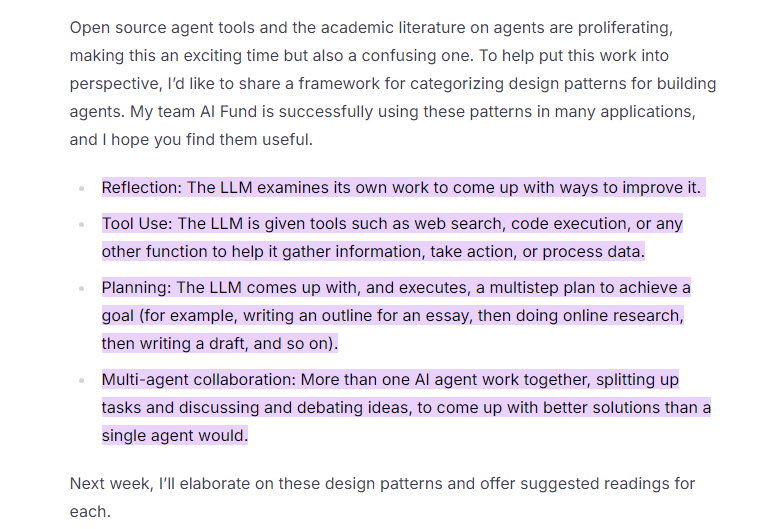